In [64]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [65]:
DA_Prices = pd.read_excel('Data/RegressionIntraday/DayAheadPrices_2021_2024.xlsx')
Demand = pd.read_excel('Data/RegressionIntraday/Demand_2021_2024.xlsx')
ID_Prices = pd.read_excel('Data/RegressionIntraday/IntradayPrices_2021_2024.xlsx')
OffshoreCapacityFactor = pd.read_excel('Data/RegressionIntraday/OffshoreCapacityFactor_2021_2024.xlsx')
OnshoreCapacityFactor = pd.read_excel('Data/RegressionIntraday/OnshoreCapacityFactor_2021_2024.xlsx')
SolarCapacityFactor = pd.read_excel('Data/RegressionIntraday/SolarCapacityFactor_2021_2024.xlsx')

### Making 15 min prices hourly

In [66]:
# Ensure the time is in string format before concatenating
DA_Prices['time_str'] = DA_Prices['(Uhrzeit) von'].astype(str)
ID_Prices['time_str'] = ID_Prices['(Uhrzeit) von'].astype(str)

# Combine the date and time columns into a single datetime column, with `dayfirst=True`
DA_Prices['timestamp'] = pd.to_datetime(DA_Prices['Datum von'] + ' ' + DA_Prices['time_str'], dayfirst=True)
ID_Prices['timestamp'] = pd.to_datetime(ID_Prices['Datum von'] + ' ' + ID_Prices['time_str'], dayfirst=True)

# Drop the temporary columns
DA_Prices.drop(columns=['time_str'], inplace=True)
ID_Prices.drop(columns=['time_str'], inplace=True)

# Drop the old date and time columns if you don't need them
DA_Prices.drop(columns=['Datum von', '(Uhrzeit) von'], inplace=True)
ID_Prices.drop(columns=['Datum von', '(Uhrzeit) von'], inplace=True)

# Set the timestamp as the index
DA_Prices.set_index('timestamp', inplace=True)
ID_Prices.set_index('timestamp', inplace=True)

# Sort the index to avoid issues during resampling
DA_Prices.sort_index(inplace=True)
ID_Prices.sort_index(inplace=True)

# Select only numeric columns for resampling
DA_Prices_numeric = DA_Prices.select_dtypes(include=['number'])
ID_Prices_numeric = ID_Prices.select_dtypes(include=['number'])

# Resampling to hourly average
DA_Prices_hourly = DA_Prices_numeric.resample('h').mean()
ID_Prices_hourly = ID_Prices_numeric.resample('h').mean()

# Remove February 29th if it exists (leap years only)
DA_Prices_hourly = DA_Prices_hourly[~((DA_Prices_hourly.index.month == 2) & (DA_Prices_hourly.index.day == 29))]
ID_Prices_hourly = ID_Prices_hourly[~((ID_Prices_hourly.index.month == 2) & (ID_Prices_hourly.index.day == 29))]




In [67]:
# Reset the index of the reference DataFrame
DA_Prices_hourly.reset_index(drop=False, inplace=True)

# Drop the original DateTime column if it exists (it is part of the index now)
if 'DateTime' in DA_Prices_hourly.columns:
    DA_Prices_hourly.drop(columns=['DateTime'], inplace=True)

# Attach (concatenate) the DataFrames horizontally
data = pd.concat([
    DA_Prices_hourly,
    ID_Prices_hourly['ID AEP in €/MWh'].reset_index(drop=True),
    Demand['Demand [GWh]'].reset_index(drop=True),
    OffshoreCapacityFactor['Capacity Factor'].reset_index(drop=True),
    OnshoreCapacityFactor['Capacity Factor'].reset_index(drop=True),
    SolarCapacityFactor['Capacity Factor'].reset_index(drop=True)
], axis=1)

# Rename the columns
data.columns = ['DateTime', 'DA_price', 'ID_price', 'Demand', 'Offshore_CF', 'Onshore_CF', 'PV_CF']

# Display the first few rows to check
print(data.head())


             DateTime  DA_price  ID_price    Demand  Offshore_CF  Onshore_CF  \
0 2021-01-01 00:00:00     50.87     45.75  44569.25     0.049267    0.072284   
1 2021-01-01 01:00:00     48.19     53.50  42806.00     0.050746    0.064923   
2 2021-01-01 02:00:00     44.68     62.00  41049.75     0.039266    0.058846   
3 2021-01-01 03:00:00     42.92     42.25  40233.75     0.041066    0.050948   
4 2021-01-01 04:00:00     40.39     39.75  40210.50     0.038108    0.045308   

     PV_CF  
0  0.00002  
1  0.00002  
2  0.00002  
3  0.00002  
4  0.00002  


In [68]:
data.fillna(0, inplace=True)

In [69]:
# Features and target variable
X = data[['DA_price', 'Demand', 'Offshore_CF', 'Onshore_CF', 'PV_CF']]
y = data['ID_price']

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
# Initialize the model
IDForecaster = LinearRegression()

# Train the model
IDForecaster.fit(X_train, y_train)

# Model coefficients
print("Model Coefficients:", IDForecaster.coef_)
print("Model Intercept:", IDForecaster.intercept_)

Model Coefficients: [ 9.40038499e-01  3.13984241e-04 -7.32993163e+00 -7.44525594e+00
 -2.81215631e+01]
Model Intercept: -0.7390519244072209


In [73]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# Define the model
ridge = Ridge()

# Define the parameter grid
param_grid = {
    'alpha': [0.1, 1.0, 10.0, 50.0, 100.0, 200.0, 500.0, 1000.0],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag', 'saga']
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)

# Run GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best R² Score during cross-validation:", best_score)

# Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_score = r2_score(y_test, y_pred)

print("R² Score on the test set:", test_score)


Best Parameters: {'alpha': 10.0, 'solver': 'auto'}
Best R² Score during cross-validation: 0.5754730081748137
R² Score on the test set: 0.6228391585140972


Mean Squared Error: 6882.303929007563
R² Score: 0.6228361123886872


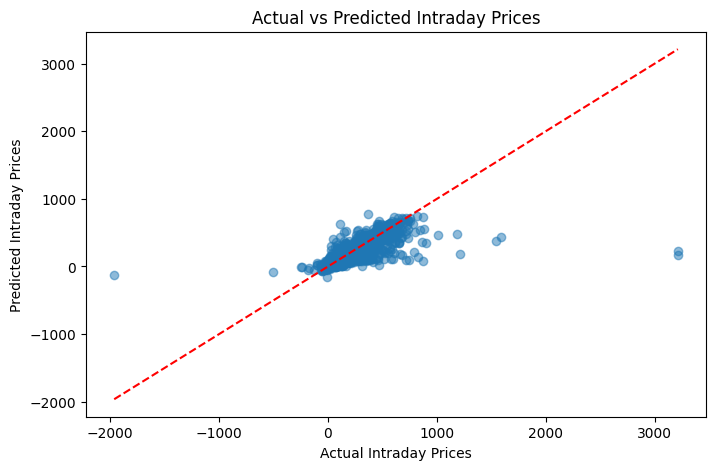

In [71]:
# Predictions
y_pred = IDForecaster.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Plotting
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Intraday Prices')
plt.ylabel('Predicted Intraday Prices')
plt.title('Actual vs Predicted Intraday Prices')
plt.show()


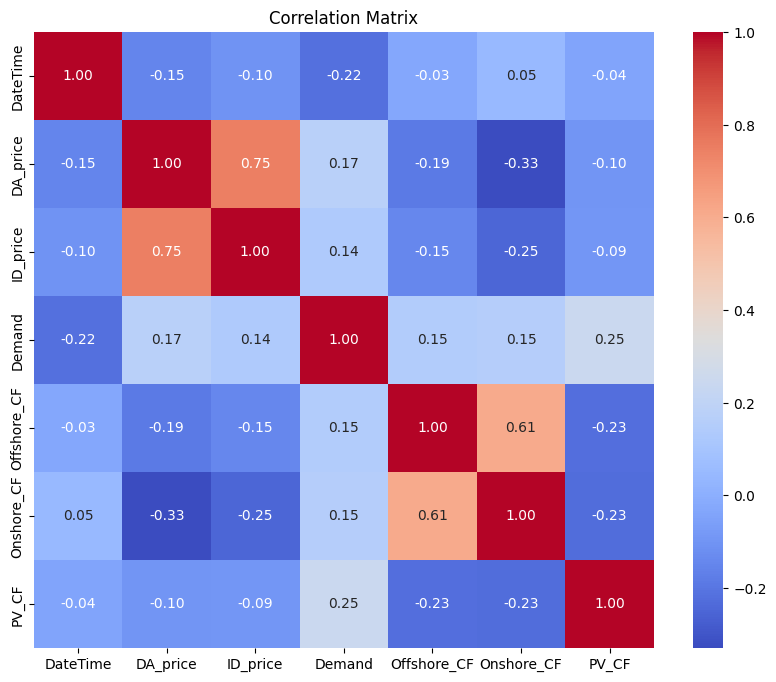

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()
